## BCG - Data Analysis Task...

In [2]:
# from IPython.display import Image
# Image(filename='bcg_data_analysis.jpg')

The BCG project team thinks that building a churn model to understand whether price sensitivity is the largest driver of churn has potential. The client has sent over some data and the LDS wants you to perform some exploratory data analysis and data cleaning.

The data that was sent over includes:

Historical customer data: Customer data such as usage, sign up date, forecasted usage etc
Historical pricing data: variable and fixed pricing data etc
Churn indicator: whether each customer has churned or not

These datasets are otherwise identical and have historical price data and customer data (including churn status for the customers in the training data).

### Table of content

In [3]:
# importing libraries

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# import the data

train = pd.read_csv('ml_case_training_data.csv',parse_dates=['date_activ','date_end','date_modif_prod','date_renewal'])
hist = pd.read_csv('ml_case_training_hist_data.csv')
churn_data = pd.read_csv('ml_case_training_output.csv')

#### Exploratory Data Analysis

In [20]:
# merge files

data = pd.merge(train,churn_data)
data.head(2)

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaT,2015-06-23,NaN,NaN,NaN,NaN,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1


In [6]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(kind="bar",
    stacked=True,
    figsize=size_,
    rot=rot_,
    title=title_)
    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()
    
def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """
    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        # Calculate annotation
        value = str(round(p.get_height(),1))
    
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(value,((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
                color=colour,
                size=textsize)


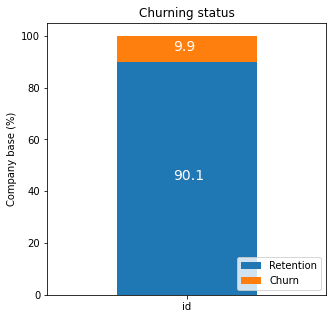

In [7]:
# Churn

churn_total = churn_data.groupby(churn_data["churn"]).count()
churn_percentage = churn_total/churn_total.sum()*100

plot_stacked_bars(churn_percentage.transpose(),"Churning status", (5,5), legend_="lower right")

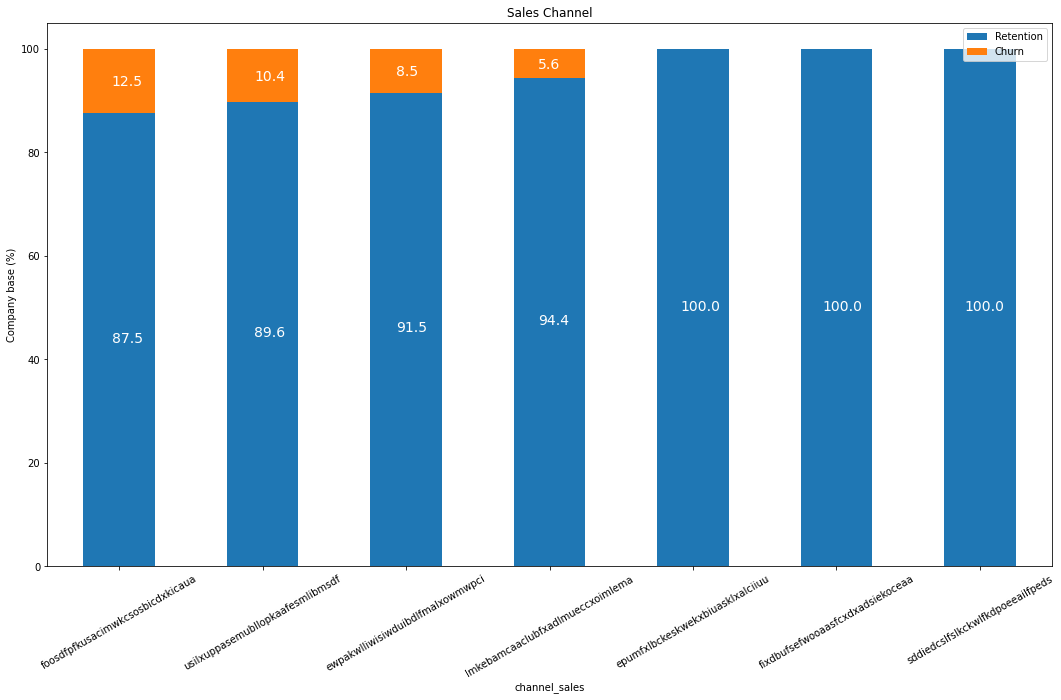

In [8]:
channel = data[["id","channel_sales", "churn"]]
channel = channel.groupby([channel["channel_sales"],
channel["churn"]])["id"].count().unstack(level=1).fillna(0)
channel_churn = (channel.div(channel.sum(axis=1), axis=0)*100).sort_values(by=[1], ascending=False)
plot_stacked_bars(channel_churn, "Sales Channel", rot_=30)

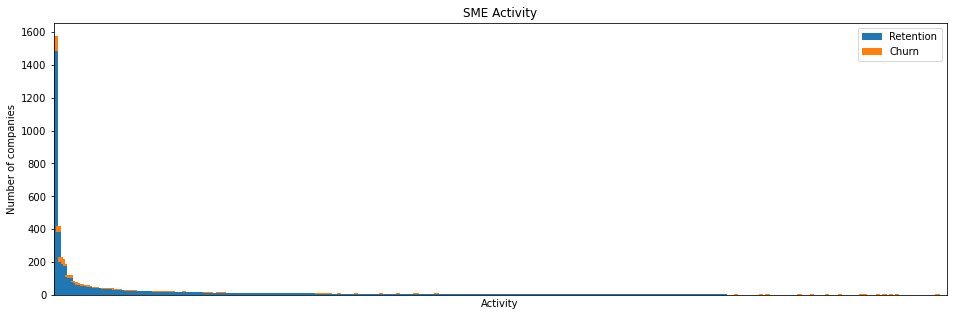

In [9]:

# plot_stacked_bars(churn_percentage.transpose(),"Churning status", (5,5), legend_="lower right")
activity = data[["id","activity_new", "churn"]]
activity = activity.groupby([activity["activity_new"],activity["churn"]])["id"].count().unstack(level=1).sort_values(by=[0], ascending=False)

activity.plot(kind="bar",
             figsize=(16,5 ),
             width=2,
             stacked=True,
             title="SME Activity")

# Labels
plt.ylabel("Number of companies")
plt.xlabel("Activity")

# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")

# Remove the label for the xticks as the categories are encoded and we can't draw any meaning from them yet
plt.xticks([])
plt.show()

#### Historical Transaction

In [10]:
#  convert the price date to datetime and set as index

hist['price_date'] = pd.to_datetime(hist.price_date)   # converting to datetime
hist = hist.set_index('price_date')  # setting as index

In [11]:
# find total price of energy and power per user for the period

hist['total_power_price'] = hist['price_p1_fix']+ hist['price_p2_fix'] + hist['price_p3_fix']
hist['total_energy_price'] = hist['price_p1_var']+ hist['price_p2_var'] + hist['price_p3_var']

In [12]:
# group transactions by user

cust_hist = hist.groupby('id').sum()
cust_hist = cust_hist.reset_index()
cust_hist[['id','total_power_price','total_energy_price']].head()

,id,total_power_price,total_energy_price
0,0002203ffbb812588b632b9e628cc38d,976.841578,3.615510
1,0004351ebdd665e6ee664792efc4fd13,532.625404,1.757118
2,0010bcc39e42b3c2131ed2ce55246e3c,543.836520,2.178702
3,0010ee3855fdea87602a5b7aba8e42de,975.538248,3.432978
4,00114d74e963e47177db89bc70108537,531.203164,1.775110


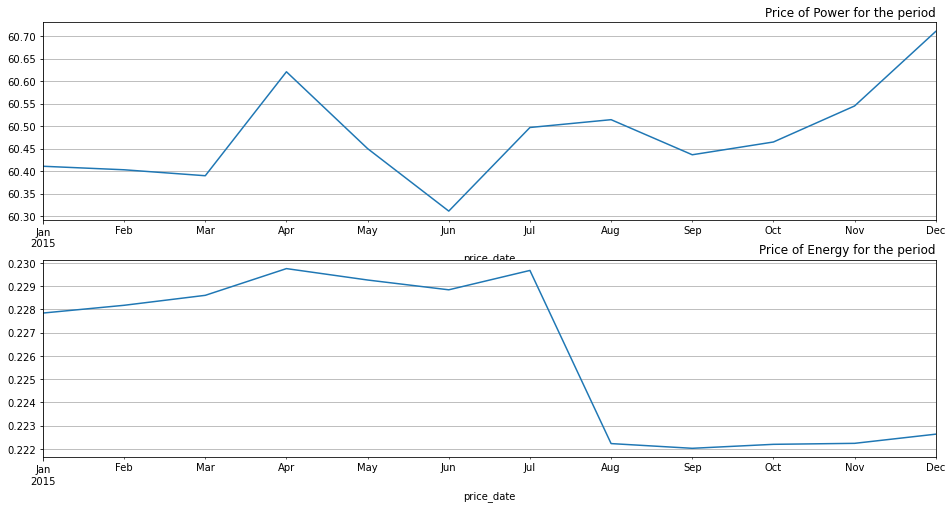

In [13]:
plt.figure(figsize=(16,8))

#Plot 1

plt.subplot(2,1,1)
hist.total_power_price.resample('M').mean().plot(scalex=False)
plt.title('Price of Power for the period', loc='right')
plt.grid()

#Plot 2

plt.subplot(2,1,2)
hist.total_energy_price.resample('M').mean().plot()
plt.title('Price of Energy for the period',loc='right')

plt.grid()
plt.show()

### Cleaning the Data

In [ ]:
plt.figure(figsize=[18,5])

data.groupby('date_renewal')['date_renewal'].count().plot()
data.groupby('date_activ')['date_activ'].count().plot()
data.groupby('date_modif_prod')['date_modif_prod'].count().plot()
data.groupby('date_activ')['date_activ'].count().plot()

plt.legend()
plt.show()

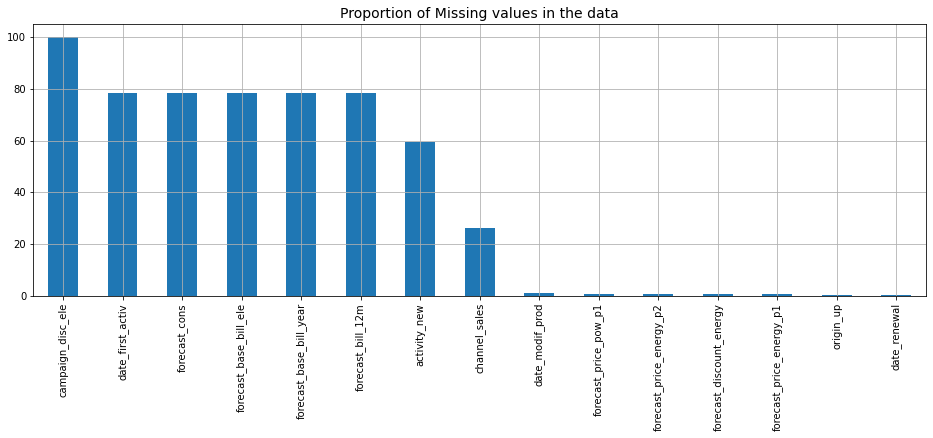

In [21]:
# Missing values

(data.isnull().mean()*100).sort_values(ascending=False)[:15].plot(kind='bar', figsize=(16,5))
plt.title('Proportion of Missing values in the data', fontsize=14)
plt.grid()
plt.show()

In [22]:
# Droping the missing columns with over 50% missing and
# Droping the rows from columns with less that 2% missing values

for feature in data.columns:
    if data[feature].isnull().mean() > 0.5:
        data.drop(feature, axis=1, inplace=True)
    
data.dropna(inplace=True, subset=['forecast_price_energy_p1','date_modif_prod','margin_gross_pow_ele','origin_up','date_renewal','net_margin'])

In [23]:
# Replace missing values in sales channel

data['channel_sales'] = data['channel_sales'].replace(np.NaN, 'missing_channel_sales')

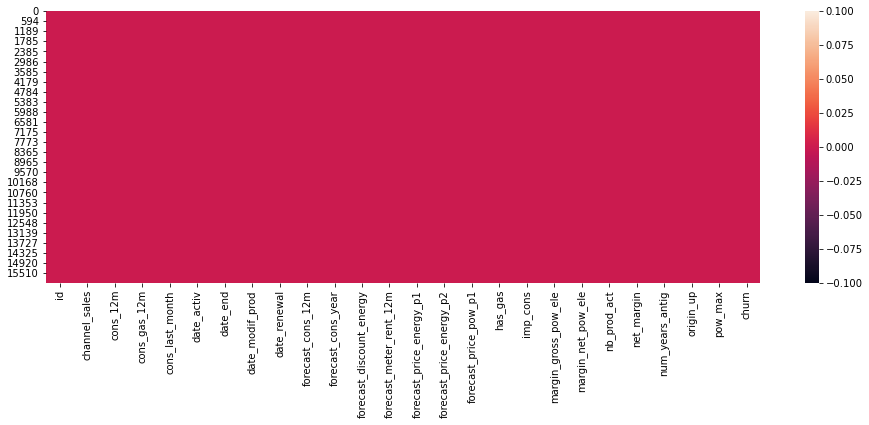

In [27]:
# Show if there is still any missing value in the data

plt.figure(figsize=(16,5))
sns.heatmap(data= data.isnull())
plt.show()

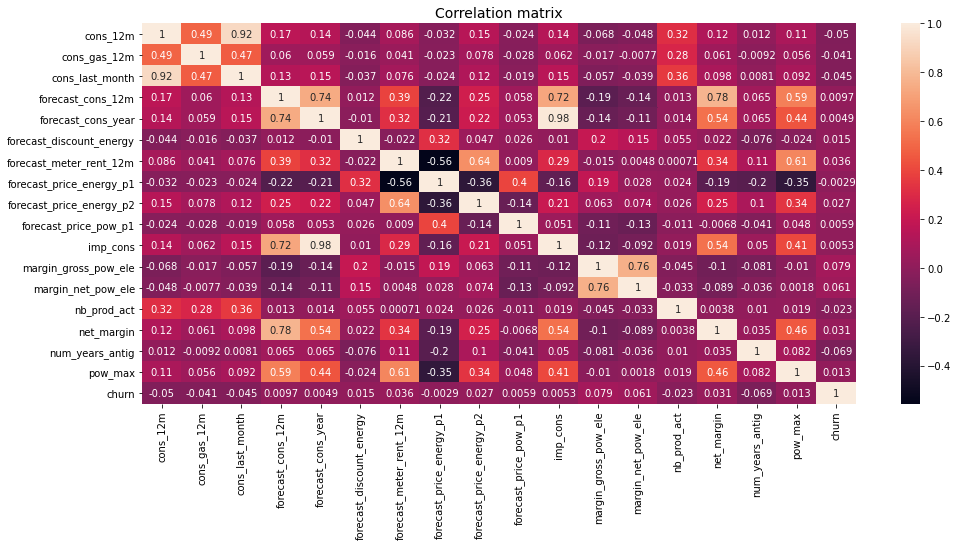

In [28]:
# showing multicolinearity in the data

plt.figure(figsize=(16,7))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation matrix', fontsize=14)
plt.show()

#### Churn

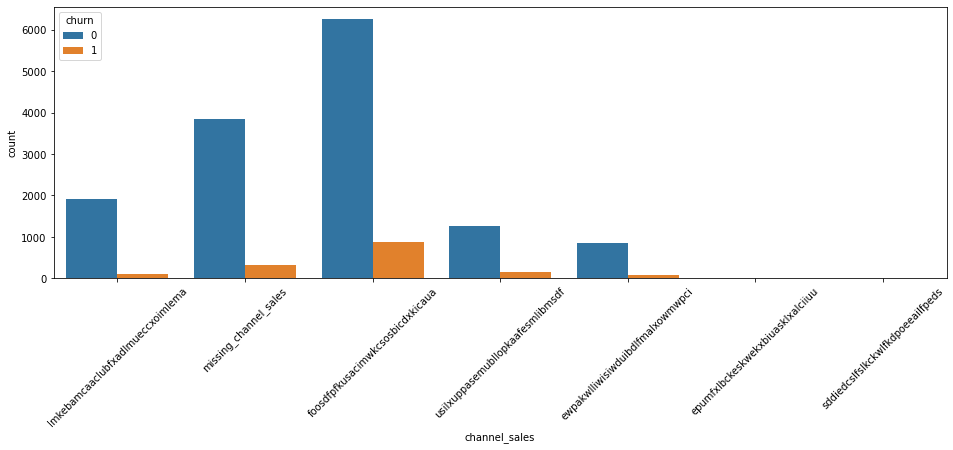

In [29]:

plt.figure(figsize=(16,5))

sns.countplot(x='channel_sales', data=data, hue='churn')
plt.xticks(rotation=45)
plt.show()

In [30]:
#  treating the outliers

Q1=data['margin_gross_pow_ele'].quantile(0.25)
Q3=data['margin_gross_pow_ele'].quantile(0.75)

IQR= Q3-Q1

Lower_Whisker = Q1-1.5 *IQR
Upper_Whisker = Q3+1.5*IQR

data = data[(data['margin_gross_pow_ele']< Upper_Whisker) & (data['margin_gross_pow_ele']> Lower_Whisker)]

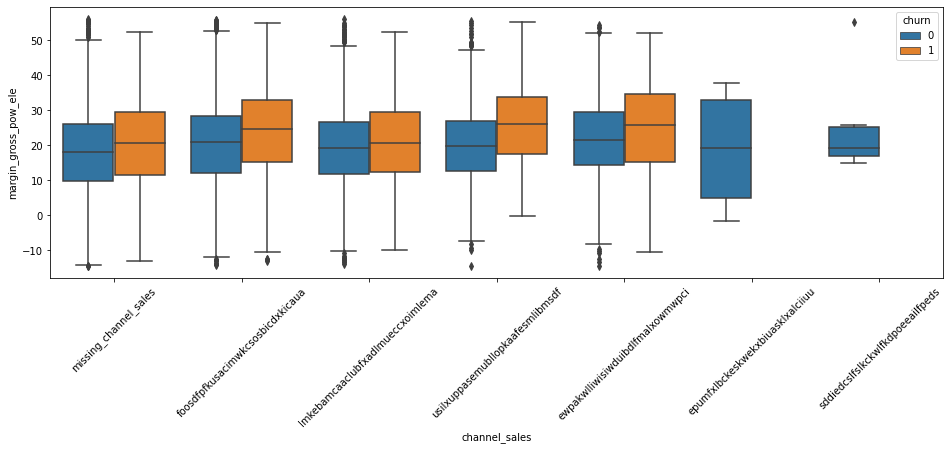

In [31]:
plt.figure(figsize=(16,5))
sns.boxplot(x='channel_sales', y='margin_gross_pow_ele', data=data, hue='churn')
plt.xticks(rotation=45)
plt.show()

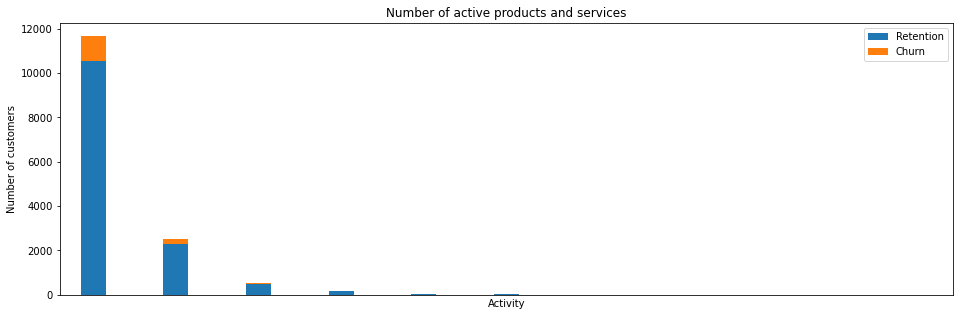

In [32]:
active_customers = data[["id","nb_prod_act", "churn"]]
active_customers = active_customers.groupby([active_customers["nb_prod_act"],active_customers["churn"]])["id"].count().unstack(level=1).sort_values(by=[0], ascending=False)

active_customers.plot(kind="bar",
             figsize=(16,5 ),
             width=.3,
             stacked=True,
             title="Number of active products and services")

# Labels
plt.ylabel("Number of customers")
plt.xlabel("Activity")

# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")

# Remove the label for the xticks as the categories are encoded and we can't draw any meaning from them yet
plt.xticks([])
plt.show()

#### Observation

Customers with fewer packages have high probability of churning

In [33]:
# merge

# data = pd.merge(train,churn_data)
data = pd.merge(data,cust_hist[['id','total_power_price','total_energy_price']])
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,total_power_price,total_energy_price
0,d29c2c54acc38ff3c0614d0a653813dd,missing_channel_sales,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,487.469573,1.649274
1,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,532.625404,3.107195
2,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,532.803183,1.814521
3,568bb38a1afd7c0fc49c77b3789b59a3,foosdfpfkusacimwkcsosbicdxkicaua,121335,0,12400,2010-04-08,2016-04-08,2010-04-08,2015-04-12,10865.02,12400,0.0,170.74,0.110083,0.093746,40.606701,f,1052.37,-3.18,-3.18,1,823.18,6,lxidpiddsbxsbosboudacockeimpuepw,75.000,0,976.189915,3.428996
4,149d57cf92fc41cf94415803a877cb4b,missing_channel_sales,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,976.515746,3.608133


In [34]:
data.to_csv('cleanse_data_file.csv')